In [12]:
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D,GlobalAveragePooling2D,Input
from keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import layers

In [13]:
# Read the file tokens_clean.txt and store the cleaned captions in a dictionary
import json

content = None

with open ("data/textFiles/tokens_clean.txt", 'r') as file:
    content = file.read()

json_acceptable_string = content.replace("'", "\"")
content = json.loads(json_acceptable_string)

In [14]:
print(type(content))

<class 'dict'>


In [15]:
#Iterate over the captions word by word, and append each word to total_words
total_words = []

for key in content.keys():
    for caption in content[key]:
        for i in caption.split():
            total_words.append(i)

print("Total Words = %d" %len(total_words))

Total Words = 1955246


In [16]:
# Compute the frequency of occurrence of each word, and store it in a dictionary of word-freq
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)

print("Number of unique words = " + str(len(freq_cnt.keys())))

Number of unique words = 18079


In [17]:
# Store the word-freq pairs (from the dictionary freq_cnt) in a list, sorted in decreasing order of frequency
sorted_freq_cnt = sorted(freq_cnt.items(), reverse=True, key=lambda x:x[1])

In [18]:
threshold = 10

#Filter off those words whose frequency of occurrence in less than threshold
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
# Store these common words in total_words
total_words = [x[0] for x in sorted_freq_cnt]

print("Number of common unique words = " + str(len(total_words)))

Number of common unique words = 5136


PREPARE TRAIN AND TEST DATA

In [19]:
# Read training and testing image names

train_file_data = ""
test_file_data = ""

with open ("data/textFiles/flickr30k_train.txt", 'r') as file:
    train_file_data = file.read()

with open ("data/textFiles/flickr30k_test.txt", 'r') as file:
    test_file_data = file.read()

In [20]:
# Obtain a list of train and test images
train_data = [img_file_name for img_file_name in train_file_data.split("\n")[:-1]]
test_data = [img_file_name for img_file_name in test_file_data.split("\n")[:-1]]

# Obtain image ID from image file name
train_data = [image.split(".")[0] for image in train_data]
test_data = [image.split(".")[0] for image in test_data]

In [21]:
train_data[:5]

['1000092795', '10002456', '1000268201', '1000344755', '1000366164']

In [22]:
# For each imageID in train_data, store its captions in a dictionary 

train_content = {}

for imageID in train_data:
    train_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = "startseq " + caption + " endseq"
        train_content[imageID].append(cap_to_append)

In [23]:
train_content['1001896054']

['startseq a man with reflective safety clothes and ear protection drives a john deere tractor on a road  endseq',
 'startseq john deere tractors cruises down a street while the driver wears easy to see clothing  endseq',
 'startseq a man in a neon green and orange uniform is driving on a green tractor  endseq',
 'startseq a man in a tractor wearing headphones driving down a paved street  endseq',
 'startseq a man driving a john deere tractor on a main road in the country  endseq']

EXTRACT FEATURES FROM IMAGES USING VGG16 ARCHIECTURE

In [27]:

# Load the VGG16 model, pre-trained on ImageNet data
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in vgg16.layers[:-4]:
    layer.trainable = False

# Create the model
model = Sequential()

# Add the VGG16 convolutional base model
model.add(vgg16)

# Add new layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Add a softmax layer with 3 output units
model.add(Dense(3, activation='softmax'))

   

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21138243 (80.64 MB)
Trainable params: 13502979 (51.51 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


In [29]:
from keras.models import Model
model_new = Model (model.input, model.layers[-2].output)

In [31]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def preprocess_image (img):
    img = image.load_img(img, target_size=(224, 224))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)

    # Convert 3D tensor to a 4D tendor
    img = np.expand_dims(img, axis=0)

    #Normalize image accoring to vgg16 requirement
    img = preprocess_input(img)

    return img

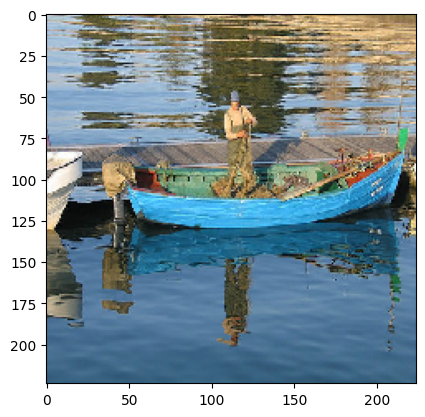

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 224, 224, 3)


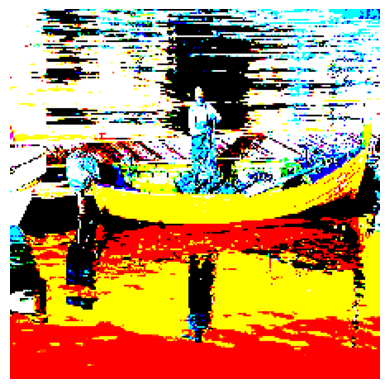

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

img = preprocess_image("data/Images/4376178.jpg")
print(img.shape)
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [17]:
# A wrapper function, which inputs an image and returns its encoding (feature vector)
def encode_image (img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)

    feature_vector = feature_vector.reshape((-1,))
    return feature_vector

In [18]:
from time import time

train_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (train_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    train_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "sec")


Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Encoding in progress... STEP 1000
Encoding in progress... STEP 1100
Encoding in progress... STEP 1200
Encoding in progress... STEP 1300
Encoding in progress... STEP 1400
Encoding in progress... STEP 1500
Encoding in progress... STEP 1600
Encoding in progress... STEP 1700
Encoding in progress... STEP 1800
Encoding in progress... STEP 1900
Encoding in progress... STEP 2000
Encoding in progress... STEP 2100
Encoding in progress... STEP 2200
Encoding in progress... STEP 2300
Encoding in progress... STEP 2400
Encoding in progress... STEP 2500
Encoding in progress... STEP 2600
Encoding in progress... STEP 2700
Encoding in progress... STEP 2800
Encoding in progress... S

Encoding in progress... STEP 23200
Encoding in progress... STEP 23300
Encoding in progress... STEP 23400
Encoding in progress... STEP 23500
Encoding in progress... STEP 23600
Encoding in progress... STEP 23700
Encoding in progress... STEP 23800
Encoding in progress... STEP 23900
Encoding in progress... STEP 24000
Encoding in progress... STEP 24100
Encoding in progress... STEP 24200
Encoding in progress... STEP 24300
Encoding in progress... STEP 24400
Encoding in progress... STEP 24500
Encoding in progress... STEP 24600
Encoding in progress... STEP 24700
Encoding in progress... STEP 24800
Encoding in progress... STEP 24900
Encoding in progress... STEP 25000
Encoding in progress... STEP 25100
Encoding in progress... STEP 25200
Encoding in progress... STEP 25300
Encoding in progress... STEP 25400
Encoding in progress... STEP 25500
Encoding in progress... STEP 25600
Encoding in progress... STEP 25700
Encoding in progress... STEP 25800
Encoding in progress... STEP 25900
Encoding in progress

In [19]:
# Store the above computed features on the disk
# Use pickle to dump the entire data
import pickle

with open("encoded_train_features.pkl", "wb") as file:
    # Pickle allows to store any object as a file on the disk
    pickle.dump(train_encoding, file)

In [20]:
test_encoding = {}
# Create a dictionary of iamgeID and its feature vector

start_time = time()
for index, imageID in enumerate (test_data):
    image_path = "data/Images/" + imageID + ".jpg"
    
    test_encoding[imageID] = encode_image(image_path)

    # Print progress
    if index%100 == 0:
        print("Encoding in progress... STEP", index)

end_time = time()
print("Total time taken:", end_time-start_time, "s")

Encoding in progress... STEP 0
Encoding in progress... STEP 100
Encoding in progress... STEP 200
Encoding in progress... STEP 300
Encoding in progress... STEP 400
Encoding in progress... STEP 500
Encoding in progress... STEP 600
Encoding in progress... STEP 700
Encoding in progress... STEP 800
Encoding in progress... STEP 900
Total time taken: 149.0283224582672 s


In [21]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(test_encoding, file)

PREPROCESS THE CAPTIONS

In [22]:
# Create the word-to-index and index-to-word mappings
word_to_index = {}
index_to_word = {}

for i, word in enumerate(total_words):
    word_to_index[word] = i+1
    index_to_word[i+1] = word

In [23]:
print(len(index_to_word))

5136


In [24]:
print(index_to_word[5])
print(word_to_index['is'])

and
7


In [25]:
# Add startseq and endseq also to the mappings
index_to_word[5137] = 'startseq'
word_to_index['startseq'] = 5137

index_to_word[5138] = 'endseq'
word_to_index['endseq'] = 5138

VOCAB_SIZE = len(word_to_index) + 1

In [26]:
print(VOCAB_SIZE)

5139


In [27]:
import pickle
with open("data/textFiles/word_to_idx.pkl", "wb") as file:
    pickle.dump(word_to_index, file)

In [28]:
with open("data/textFiles/idx_to_word.pkl", "wb") as file:
    pickle.dump(index_to_word, file)

In [29]:
# Get the maximum length of a caption
max_len = 0

for cap_list in train_content.keys():
    for caption in train_content[cap_list]:
        max_len = max(max_len, len(caption.split()))

In [30]:
print(max_len)

80


In [31]:
# Get the Glove word Embeddings
# This contains 50-dimensional embeddings for 6 Billion English words
file = open("glove.6B.50d.txt",encoding='utf8')

In [32]:
# Create a mapping from word to embedding
embeddings_index = {} # empty dictionary

for line in file:
    values = line.split()

    word = values[0]
    coefs = np.array (values[1:], dtype='float')
    embeddings_index[word] = coefs

file.close()

In [33]:
embeddings_index["apple"]

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [34]:
embedding_dim = 50

embedding_matrix = np.zeros((VOCAB_SIZE, embedding_dim))

for word, i in word_to_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [35]:
embedding_matrix.shape

(5139, 50)

DEFINE MODEL ARCHITECTURE

In [36]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM

#Convert feature vector of image to smaller vector

#Output of VGG16 goes into following input layer 
inp_img_features = Input(shape=(2048,))

inp_img1 = Dropout(0.3)(inp_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [37]:
#Now take Captions as input

#Actual input size will be (batch_size x max_length_of_caption)
#But here we specify only for one example
inp_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=VOCAB_SIZE, output_dim=50, mask_zero=True)(inp_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)
# inp_cap3 captures the entire sentence that has been generated till now

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [38]:
from keras.layers.merge import add

# Decode the inputs

# So, an image (224x224x3) goes through vgg16
# Then as 2048 dimensional it goes through the above earlier architecture
# The final output is inp_img2 (256 dimensional) which now goes through the Decoder 

# Similarly for the captions which initially have shape (batch_size x max_len)
# Then after passing through Embedding layer comes out as (batch_size x max_len x 50(embedding_size)))
# Then it passes through the above LSTM layer and comes out as inp_cap3 (a 256 dimensional vector)

# Add the two above tensors
decoder1 = add([inp_img2, inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(VOCAB_SIZE, activation='softmax')(decoder2)

# Combined model
model = Model (inputs=[inp_img_features, inp_cap], outputs=outputs)

In [39]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 80)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 80, 50)       256950      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

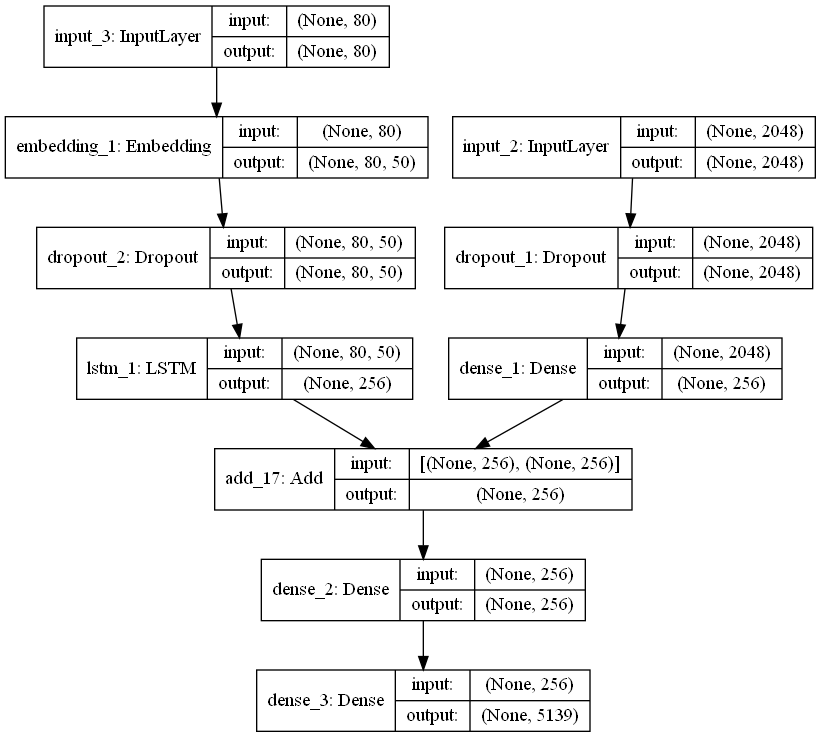

In [40]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [41]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [42]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

In [43]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def data_generator (train_content, train_encoding, word_to_index, max_len, batch_size):
    X1, X2, y = [], [], []
    n = 0

    while True:
        for imageID, cap_list in train_content.items():
            n += 1

            image = train_encoding [imageID]

            for caption in cap_list:
                idx_seq = [word_to_index[word] for word in caption.split() if word in word_to_index]

                for i in range (1, len(idx_seq)):
                    xi = idx_seq[0 : i] # The input sequence of words
                    yi = idx_seq[i] # The next word after the above sequence (this is expected to be predicted)

                    # Add a padding of zeros ao lengths of input sequences become equal
                    xi = pad_sequences([xi], maxlen=max_len, value=0, padding='post')[0] # Take the first row only, since this method inputs & returns a 2D array
                    # Convert the expected word to One Hot vector notation
                    yi = to_categorical([yi], num_classes=VOCAB_SIZE)[0]

                    X1.append(image)
                    X2.append(xi)
                    y.append(yi)

                if n==batch_size:
                    yield [[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y = [], [], []
                    n=0

TRAIN THE MODEL

In [44]:
epochs = 15
batch_size = 5
steps = len(train_content)//batch_size

In [45]:
for i in range(epochs):
    # Create an instance of the generator
    generator = data_generator(train_content, train_encoding, word_to_index, max_len, batch_size)
    model.fit_generator(generator, steps_per_epoch=steps)
    model.save('model_' + str(i) + '.h5')

Epoch 1/1
5800/5800 [==============================] - 4879s 841ms/step - loss: 3.8658
Epoch 1/1
5800/5800 [==============================] - 4925s 849ms/step - loss: 3.3300
Epoch 1/1
5800/5800 [==============================] - 4944s 852ms/step - loss: 3.1881
Epoch 1/1
5800/5800 [==============================] - 4951s 854ms/step - loss: 3.1141
Epoch 1/1
5800/5800 [==============================] - 4956s 854ms/step - loss: 3.0679
Epoch 1/1
5800/5800 [==============================] - 4960s 855ms/step - loss: 3.0363
Epoch 1/1
5800/5800 [==============================] - 4952s 854ms/step - loss: 3.0136
Epoch 1/1
5800/5800 [==============================] - 4958s 855ms/step - loss: 2.9966
Epoch 1/1
5800/5800 [==============================] - 4951s 854ms/step - loss: 2.9813
Epoch 1/1
5800/5800 [==============================] - 4954s 854ms/step - loss: 2.9706
Epoch 1/1
5800/5800 [==============================] - 4939s 852ms/step - loss: 2.9625
Epoch 1/1
5800/5800 [======================

In [46]:
model.load_weights('./model_checkpoints/model_14.h5')

In [47]:
images = './data/Images/'

In [48]:
from pickle import dump, load
with open("./encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [49]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_len):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = index_to_word[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [50]:
z = 0

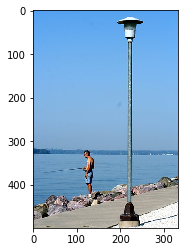

Greedy: a man is walking on a beach with a fishing pole
1313869424


In [90]:
#z = 0
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))
print(pic)

In [91]:
test_content = {}

for imageID in test_data:
    test_content[imageID] = []
    for caption in content[imageID]:
        # Add a start sequence token in the beginning and an end sequence token at the end
        cap_to_append = caption
        test_content[imageID].append(cap_to_append)

In [92]:
x = 0
pic = list(encoding_test.keys())[x]
test_content[pic]

['the man with pierced ears is wearing glasses and an orange hat ',
 'a man with glasses is wearing a beer can crocheted hat ',
 'a man with gauges and glasses is wearing a blitz hat ',
 'a man in an orange hat starring at something ',
 'a man wears an orange hat and glasses ']

102617084
Greedy Search Caption: a group of people are walking down a snowy path

Reference 1: ['five snowmobile riders all wearing helmets and goggles line up in a snowy clearing in a forest in front of their snowmobiles they are all wearing black snow pants and from left to right they are wearing a black coat white coat red coat blue coat and black coat ', 'five people wearing winter jackets and helmets stand in the snow with snowmobiles in the background ', 'five people wearing winter clothing helmets and ski goggles stand outside in the snow ', 'a group of snowmobile riders gather in the snow ', 'group gathered to go snowmobiling ']

BLEU-1: 0.738


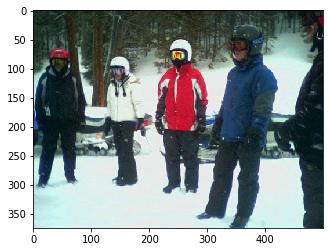

In [101]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

x = 3
pic = list(encoding_test.keys())[x]
test_content[pic]


reference = test_content[pic]
#pic = list(encoding_test.keys())[1]
#print(pic)
#img = 'twodogs.jpg'
e = encoding_test[pic].reshape(1,2048)
#image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic+'.jpg')
#x=plt.imread(img)
plt.imshow(x)
# plt.show()
caption = greedySearch(e)
print("Greedy Search Caption:",caption)
print()
print('Reference 1:',reference)

print()
print('BLEU-1:', round(sentence_bleu(reference, caption),3))